In [2]:
import nltk
import re
#nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
from pattern.en import singularize
import json
from textblob import TextBlob
import pyLDAvis.gensim
from wordcloud import WordCloud
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Importing Gensim and it's dependencies
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim 
from gensim import models, corpora

In [4]:
def read_data(data_training):
    original_text = []    
    for i in range(len(data_training['commands'])):
        original_text.append(data_training['commands'][i]['description']) 
    return original_text

def isplural(pluralForm):
     singularForm = singularize(pluralForm)
     #plural = True if pluralForm is not singularForm else False
     return singularForm

nounls = ['geese', 'mice', 'bars', 'foos', 'foo', 'sessions',
            'families', 'family', 'dog', 'dogs']

for pluralForm in nounls:
    singularForm = isplural(pluralForm)
    print ( singularForm)

In [5]:
def clean_data(original_text):
    text =''
    stop_words_removed = ''
    updated_text=''
    text = word_tokenize(str(original_text).lower())
    tokens = [get_lemma(token) for token in text]
    tokens = [isplural(token) for token in tokens]
    stop_words_removed = remove_stopwords(tokens)
    return stop_words_removed

In [6]:
def remove_stopwords(text):
    cleaned_text = [t for t in text if t not in stop_words and re.match(r'[a-zA-Z\-][a-zA-Z\-]{3,}', t)]
    #cleaned_text = [t for t in text if t not in stop_words]
    return cleaned_text

In [7]:
def get_lemma(word):
    lemma = wn.morphy(word)
    # print('yes', lemma)
    if lemma is None:
        return word
    else:
        return lemma

In [8]:
def test_doc(lda_model, id2word_train, new_doc):
    tokenized_data = clean_data(new_doc)
    new_doc_bow = id2word_train.doc2bow(tokenized_data)
    zz = lda_model.get_document_topics(new_doc_bow)
    topics_list_z = []
    topics_prob_list_z = []
    for y in range(len(zz)):
        topics_list_z.append(zz[y][0])
        topics_prob_list_z.append(zz[y][1])
    max_value = max(topics_prob_list_z)
    max_index = topics_prob_list_z.index(max_value)
    #print('Dominant Topic is: ', topics_list_z[max_index], ' with a prob of: ',max_value )
    return topics_list_z[max_index]

In [9]:
# For gensim we need to tokenize the data and filter out stopwords
def create_corpus(data):
    tokenized_data = []
    for text in data:
        tokenized_data.append(clean_data(text))   
    id2word = corpora.Dictionary(tokenized_data)
    texts = tokenized_data
    corpus = [id2word.doc2bow(text) for text in texts]
    return texts, id2word, corpus

In [10]:
def create_a_string_from_topics(pop_topics):
    full_list_topics = dict()
    for j in range(len(pop_topics)):
        empty_list = []
        key = pop_topics[j][0]
        for p in pop_topics[j][1].split('+'):
            empty_list.append(p.split('*')[1][1:-1])
        new_list = [item.replace('"',"") for item in empty_list]
        full_list_topics[key] = new_list 
    for k, v in full_list_topics.items():
        print(k, v, '\n') 

In [11]:
def find_number_of_topics(corpus_train, id2word_train):
    coherence_values = []
    number_of_topics = []
    for num_topics in range(2, 20, 1):
        lda_model_coh =   models.LdaModel(corpus=corpus_train, id2word=id2word_train, num_topics=num_topics, passes=100,
                           alpha='auto', per_word_topics=True, update_every=1,  random_state=123, chunksize=100) 
        number_of_topics.append(num_topics)
        coherence_model_lda = CoherenceModel(model=lda_model_coh, texts=clean_tokenized, dictionary=id2word_train, coherence='c_v')
        coherence_values.append(coherence_model_lda.get_coherence())
    sns.set()
    plt.plot(number_of_topics, coherence_values)
    labels = [0,2,4,6,8,10,12,14,16,18,20,22]
    plt.xticks(labels)
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.tight_layout()
    #plt.savefig('./results/windows_topics_coherence.png');
    plt.show();
    return number_of_topics, coherence_values


In [12]:
def find_dominant_topics(data, lda_model, corpus_train):
    docs_topics_df = pd.DataFrame(columns= ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])
    topics_docs = list()
    for m in lda_model[corpus_train]:
        topics_docs.append(m)

    for tt in range(len(topics_docs)):
        topics_list = []
        topics_prob_list = []
        for j in range(len(topics_docs[tt][0])):
            topics_list.append(topics_docs[tt][0][j][0])
            topics_prob_list.append(topics_docs[tt][0][j][1])
        max_value = max(topics_prob_list)
        max_index = topics_prob_list.index(max_value)
        topic_num = topics_list[max_index]
        wp = lda_model.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        docs_topics_df = docs_topics_df.append({'Dominant_Topic': int(topic_num),'Perc_Contribution': round(max_value,4),
                                           'Topic_Keywords': topic_keywords}, ignore_index=True)

    docs_topics_df['Command'] = ''
    for y in range(len(data['commands'])):
        docs_topics_df.loc[y,'Command']= data['commands'][y]['commands']
    docs_topics_df = docs_topics_df[['Command', 'Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']]
    return docs_topics_df

In [13]:
def plot_prob_topics_box(docs_topics_df):
    sns.set()
    fig = plt.figure(figsize=(8,6))
    sns.boxplot(docs_topics_df['Dominant_Topic'], docs_topics_df['Perc_Contribution'])
    plt.ylabel('Probabilities')
    plt.tight_layout()
    #plt.savefig('./results/topics_probabilities.png')
    plt.show()

In [14]:
def plot_ratios_sim_topic(data, sim_df, lda_model, id2word_train):
    commands_list = []
    for w in range(len(data['commands'])):
        commands_list.append(data['commands'][w]['commands'])
    correct_topic = []
    mismatch_topic = []
    correct_value = 0
    mismatch_value = 0
    for x in range(len(sim_df)):
        comm1, comm2 = sim_df.loc[x]['comm1'],  sim_df.loc[x]['comm2']
        comm1_index = commands_list.index(comm1)
        comm2_index = commands_list.index(comm2)
        comm1_desc = data['commands'][comm1_index]['description']
        comm2_desc = data['commands'][comm2_index]['description']
        comm1_topic = test_doc(lda_model, id2word_train, comm1_desc)
        comm2_topic = test_doc(lda_model, id2word_train, comm2_desc)
        if comm1_topic==comm2_topic:
            correct_topic.append([comm1, comm2])
            correct_value+=1
        else:
            mismatch_topic.append([comm1, comm2])
            mismatch_value+=1
        
    correct_ratio = correct_value/len(sim_df)  
    mismatch_ratio = mismatch_value/len(sim_df)
    x = [correct_ratio, mismatch_ratio]
    x_df = pd.DataFrame(x, columns=['Ratio'])
    x_df['Result'] = ''
    x_df.loc[0, 'Result'] = 'Correct'
    x_df.loc[1, 'Result'] = 'Incorrect'

    palette = ['royalblue', 'green']
    g = sns.barplot(x = 'Result', y='Ratio', data=x_df, palette=palette)
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax=g
    #annotate axis = seaborn axis
    for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                 textcoords='offset points')
    _ = g.set_ylim(0,1.0) 
    return x_df

In [15]:
stop_words = stopwords.words('english')
lemmatiser = WordNetLemmatizer()
lemmatized_data = []

# WINDOWS ANALYSIS

In [16]:
with open('./data/windows/windows_data.txt', 'r') as read_file:
    windows_data = json.load(read_file)

In [17]:
windows_data_train = read_data(windows_data)
clean_tokenized, id2word_train, corpus_train =  create_corpus(windows_data_train)

C:\Hyapp\Anaconda3-2019.3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Hyapp\Anaconda3-2019.3\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


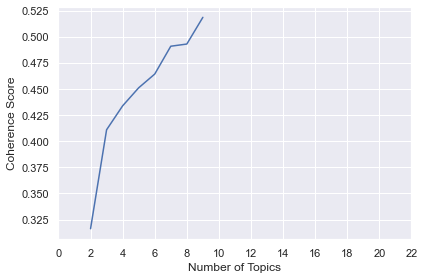

In [19]:
number_of_topics, coherence_values_windows = find_number_of_topics(corpus_train, id2word_train)

In [26]:
lda_model = models.LdaModel(corpus=corpus_train, 
                            id2word=id2word_train, 
                            num_topics=10, chunksize=100,
                           passes=100,
                           alpha='auto',
                           per_word_topics=True,
                           update_every=1,
                           random_state=35) 

In [27]:
pop_topics = lda_model.print_topics(10)
create_a_string_from_topics(pop_topics)

4 ['dump', 'crash', 'ntfr', 'real-time', 'tracerpt', 'schema', 'important', 'keeping', 'thread', 'convenient'] 

0 ['next', 'queue', 'mount', 'acros', 'timeout', 'messaging', 'technology', 'expiration', 'efficient', 'priority-based'] 

2 ['content', 'cache', 'download', 'flag', 'clear', 'peer', 'serve', 'maintain', 'get-content', 'cmdlet'] 

1 ['client', 'request', 'telnet', 'tapus', 'microsoft', 'resource', 'certificate', 'identifier', 'http', 'transactional'] 

8 ['switch', 'line', 'performance', 'disable', 'monitor', 'reset', 'guid', 'counter', 'bitsadmin', 'trace'] 

3 ['remote', 'server', 'desktop', 'proces', 'store', 'space', 'send', 'nslookup', 'report', 'pushd'] 

11 ['drive', 'path', 'recovery', 'addition', 'encryption', 'storage', 'point', 'view', 'restart', 'recommend'] 

6 ['volume', 'copy', 'host', 'disk', 'hard', 'link', 'batch', 'virtual', 'fail', 'location'] 

7 ['service', 'window', 'server', 'domain', 'network', 'configuration', 'registry', 'protocol', 'driver', 'scri

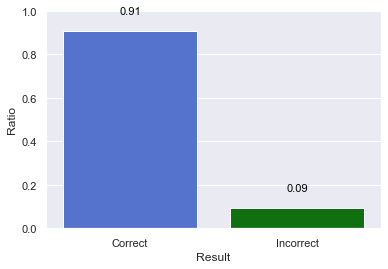

In [28]:
sns.set()
win_desc_sim = pd.read_csv('./data/windows/windows_high_sim_description_75.csv')
x_df_windows = plot_ratios_sim_topic(windows_data, win_desc_sim, lda_model, id2word_train )

In [98]:
windows_topics = find_dominant_topics(windows_data, lda_model, corpus_train)
windows_topics

,Command,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,active,3,0.6668,"disk, partition, remote, boot, path, dynamic, ..."
1,add,14,0.5789,"drive, addition, environment, load, metadatum,..."
2,add alias,14,0.7093,"drive, addition, environment, load, metadatum,..."
3,add volume,4,0.6203,"volume, copy, link, restart, creation, context..."
4,append,0,0.3317,"file, directory, recovery, utility, event, vie..."
...,...,...,...,...
680,winsat mfmedia,6,0.1425,"service, window, network, configuration, proto..."
681,wmic,6,0.1425,"service, window, network, configuration, proto..."
682,writer,7,0.5751,"group, session, administrator, local, server, ..."
683,wscript,6,0.4107,"service, window, network, configuration, proto..."


In [99]:
windows_topics.to_csv('./data/windows/windows_dominant_topics.csv', index=False)

In [100]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=clean_tokenized, dictionary=id2word_train, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)
print('\nPerplexity: ', lda_model.log_perplexity(corpus_train))

Coherence Score:  0.4171881748551691

Perplexity:  -12.478049669004465


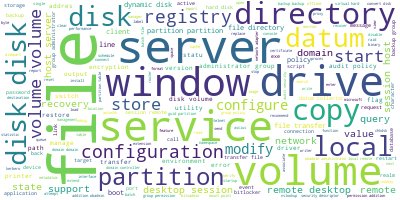

In [94]:
long_string = ','.join([item for sublist in clean_tokenized for item in sublist])
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()
#wordcloud.to_file('./results/wordcloud.png')

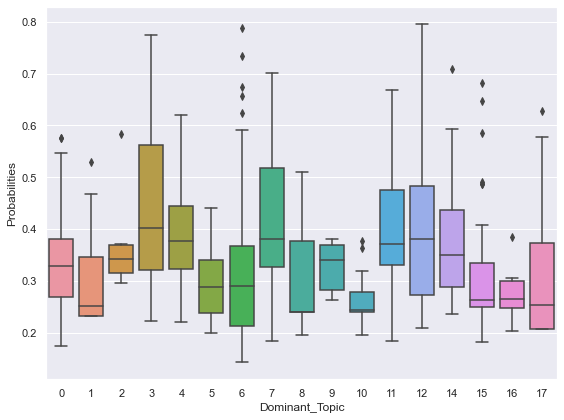

In [79]:
plot_prob_topics_box(windows_topics)

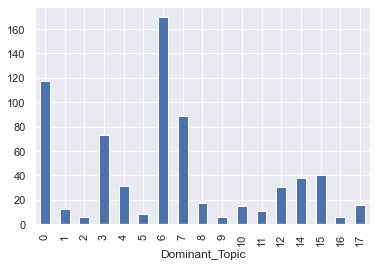

In [80]:
windows_topics.groupby(['Dominant_Topic']).size().plot.bar();

In [49]:
# erase commands
new_doc = 'Deletes one or more files. If you use erase to delete a file from your disk, you can\'t retrieve it. \
This command is the same as the del command.'

test_doc(lda_model, id2word_train, new_doc)

0

In [50]:
# del command
new_doc = 'Deletes one or more files. This command performs the same actions as the erase command. \
If you use del to delete a file from your disk, you can\'t retrieve it.'
test_doc(lda_model, id2word_train, new_doc)

0

In [51]:
# create volume simple command
new_doc = 'Creates a simple volume on the specified dynamic disk. \
After you create the volume, the focus automatically shifts to the new volume.'

test_doc(lda_model, id2word_train, new_doc)

17

In [30]:
# create volume stripe command
new_doc = 'Creates a striped volume using two or more specified dynamic disks. \
After you create the volume, the focus automatically shifts to the new volume.'

test_doc(lda_model, id2word_train, new_doc)

17

In [31]:

# create volume raid command
new_doc = 'Creates a RAID-5 volume using three or more specified dynamic disks. \
After you create the volume, the focus automatically shifts to the new volume.'

test_doc(lda_model, id2word_train, new_doc)

17

In [32]:
# create volume mirror
new_doc ='Creates a volume mirror by using the two specified dynamic disks. \
After the volume has been created, the focus automatically shifts to the new volume.'

test_doc(lda_model, id2word_train, new_doc)

17

In [33]:
# ipconfig command
new_doc = 'Displays all current TCP/IP network configuration values and refreshes Dynamic Host Configuration Protocol (DHCP)\
and Domain Name System (DNS) settings. Used without parameters, ipconfig displays Internet Protocol version 4 (IPv4) and IPv6 \
addresses, subnet mask, and default gateway for all adapters.'

test_doc(lda_model, id2word_train, new_doc)

7

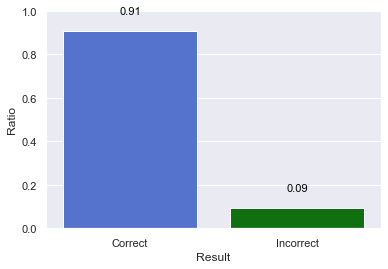

In [29]:
sns.set()
win_desc_sim = pd.read_csv('./data/windows/windows_high_sim_description_75.csv')
x_df_windows = plot_ratios_sim_topic(windows_data, win_desc_sim, lda_model, id2word_train )

# LINUX ANALYSIS

In [27]:
with open('./data/linux/linux_data.txt', 'r') as read_file:
    linux_data = json.load(read_file)

In [28]:
linux_data_train = read_data(linux_data)
clean_tokenized, id2word_train, corpus_train =  create_corpus(linux_data_train)

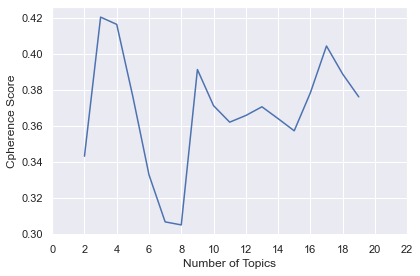

In [37]:
number_of_topics, coherence_values_linux = find_number_of_topics(corpus_train, id2word_train)

In [29]:
lda_model = models.LdaModel(corpus=corpus_train, 
                            id2word=id2word_train, 
                            num_topics=18, chunksize=100,
                           passes=100,
                           alpha='auto',
                           per_word_topics=True,
                           update_every=1,
                           random_state=39) 

In [30]:
pop_topics = lda_model.print_topics(18)
create_a_string_from_topics(pop_topics)

0 ['root', 'dump', 'core', 'combination', 'ctrl-', 'partition', 'systemd-coredump', 'journal', 'devlink', 'disk'] 

1 ['link', 'flag', 'namespace', 'window', 'storage', 'main', 'extend', 'privilege', 'symbolic', 'design'] 

2 ['value', 'mount', 'addres', 'port', 'interface', 'boot', 'report', 'unit', 'protocol', 'statistic'] 

3 ['kernel', 'table', 'linux', 'selinux', 'column', 'swap', 'context', 'security', 'repair', 'cache'] 

4 ['package', 'destination', 'repository', 'install', 'pathname', 'instal', 'source', 'printing', 'relevant', 'cancel'] 

5 ['server', 'route', 'connection', 'client', 'connect', 'regular', 'expression', 'rdma', 'resolve', 'bind'] 

6 ['password', 'query', 'clas', 'plugin', 'series', 'certificate', 'ieee', 'sink', 'patch', 'qdisc'] 

7 ['directory', 'character', 'page', 'search', 'build', 'locate', 'manual', 'font', 'groff', 'found'] 

8 ['file', 'output', 'line', 'read', 'input', 'write', 'format', 'content', 'cluster', 'monitor'] 

9 ['group', 'proces', 'sess

In [31]:
linux_topics = find_dominant_topics(linux_data, lda_model, corpus_train)
linux_topics

,Command,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,ac,3,0.2325,"kernel, table, linux, selinux, column, swap, c..."
1,addftinfo,7,0.3490,"directory, character, page, search, build, loc..."
2,addr2line,12,0.4726,"argument, datum, support, print, line, flow, c..."
3,afmtodit,7,0.5879,"directory, character, page, search, build, loc..."
4,apropos,12,0.2755,"argument, datum, support, print, line, flow, c..."
...,...,...,...,...
2242,yum,12,0.2843,"argument, datum, support, print, line, flow, c..."
2243,yumdb,12,0.3079,"argument, datum, support, print, line, flow, c..."
2244,zdump,12,0.3674,"argument, datum, support, print, line, flow, c..."
2245,zic,8,0.4007,"file, output, line, read, input, write, format..."


In [32]:
linux_topics.to_csv('./data/linux/linux_dominant_topics.csv', index=False)

In [33]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=clean_tokenized, dictionary=id2word_train, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)
print('\nPerplexity: ', lda_model.log_perplexity(corpus_train))

Coherence Score:  0.3678000207621519

Perplexity:  -14.017502392936612


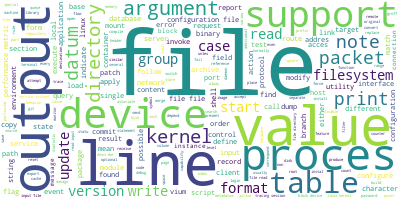

In [34]:
long_string = ','.join([item for sublist in clean_tokenized for item in sublist])
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()
#wordcloud.to_file('./results/wordcloud.png')

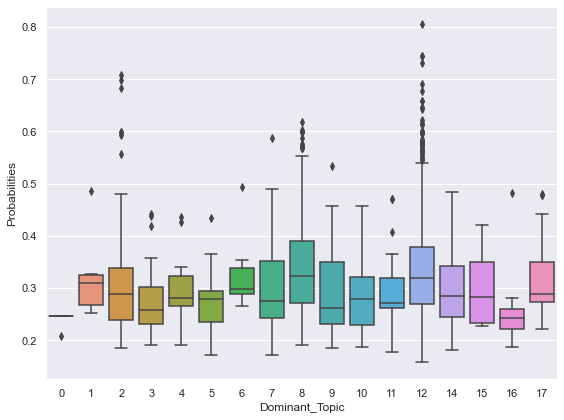

In [35]:
plot_prob_topics_box(linux_topics)

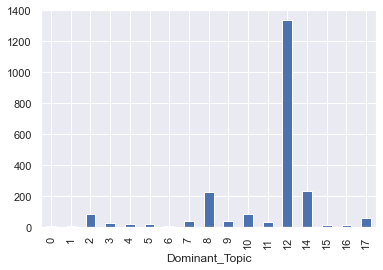

In [36]:
linux_topics.groupby(['Dominant_Topic']).size().plot.bar();

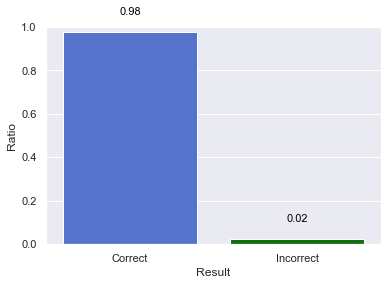

In [37]:
lin_desc_sim = pd.read_csv('./data/linux/linux_high_sim_description_75.csv')
x_df_linux = plot_ratios_sim_topic(linux_data, lin_desc_sim, lda_model, id2word_train)

In [105]:
x_df_linux, x_df_windows

(      Ratio           Result
 0  0.976147    Linux_Correct
 1  0.023853  Linux_Incorrect,
       Ratio             Result
 0  0.830189    Windows_Correct
 1  0.169811  Windows_Incorrect
 0  0.976147      Linux_Correct
 1  0.023853    Linux_Incorrect)

In [ ]:
# Basename commands
new_doc = 'Print NAME with any leading directory components removed. If specified, also remove a trailing SUFFIX. Mandatory \
arguments to long options are mandatory for short options too.'
test_doc(lda_model, id2word_train, new_doc)

In [ ]:
# Bash commands
new_doc = 'bash- GNU Bourne-Again SHell Bash is an sh-compatible command language interpreter that executes commands read from \
the standard input or from a file. Bash also incorporates useful features from the Korn and C shells (ksh and csh). Bash is \
intended to be a conformant implementation of the Shell and Utilities portion of the IEEE POSIX specification \
(IEEE Standard 1003.1). Bash can be configured to be POSIX-conformant by default..'
test_doc(lda_model, id2word_train, new_doc)

In [ ]:
# cat commands
new_doc = 'Concatenate FILE(s) to standard output. With no FILE, or when FILE is -, read standard input.'
test_doc(lda_model, id2word_train, new_doc)

In [ ]:
# echo commands
new_doc = 'Echo the STRING(s) to standard output.'
test_doc(lda_model, id2word_train, new_doc)

In [ ]:
# ip-address command
new_doc = linux_data['commands'][1495]['description']

test_doc(lda_model, id2word_train, new_doc)

In [ ]:
# write command
new_doc = linux_data['commands'][1256]['description']

test_doc(lda_model, id2word_train, new_doc)

In [ ]:
new_doc = 'yum-utils is a collection of tools and programs for managing yum repositories, installing debug packages, source \
packages, extended information from repositories and administration.'
test_doc(lda_model, id2word_train, new_doc)

In [ ]:
# wget command
new_doc = linux_data['commands'][1248]['description']

test_doc(lda_model, id2word_train, new_doc)

In [ ]:
# pfifo command
new_doc = 'The pfifo and bfifo qdiscs are unadorned First In, First Out queues. They are the simplest queues possible and \
therefore have no overhead. pfifo constrains the queue size as measured in packets.  bfifo does  so as measured in bytes. Like \
all non-default qdiscs, they maintain statistics. This might bea reason to prefer pfifo or bfifo over the default.'
test_doc(lda_model, id2word_train, new_doc)

In [ ]:

lda_display = pyLDAvis.gensim.prepare(lda_model, corpus_train, id2word_train, sort_topics=False)
pyLDAvis.display(lda_display)

In [ ]:
# attributes command
new_doc = 'Displays, sets, or clears the attributes of a disk or volume.'
test_doc(lda_model, id2word_train, new_doc)

In [ ]:
windows_data_train = read_data(windows_data)
clean_tokenized, id2word_train, corpus_train =  create_corpus(windows_data_train)

In [ ]:
new_doc = 'Displays, sets, or clears the attributes of a volume.'
test_doc(lda_model, id2word_train, new_doc)

In [ ]:
from gensim.models import LsiModel

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
lsamodel = LsiModel(corpus_train, num_topics=14, id2word = id2word_train)  # train model
print(lsamodel.print_topics(num_topics=14))

In [ ]:
pop_topics = lsamodel.print_topics(14)
create_a_string_from_topics(pop_topics)

In [ ]:
coherencemodel = CoherenceModel(model=lsamodel, texts=clean_tokenized, dictionary=id2word_train, coherence='c_v')
#        coherence_values.append(coherencemodel.get_coherence())

In [ ]:
coherence_score = coherencemodel.get_coherence()
print('Coherence Score: ', coherence_score)

In [ ]:
cmd_des_wind = []
for i in range(len(linux_data['commands'])):
    cmd = linux_data['commands'][i]['commands']
    des = linux_data['commands'][i]['description']
    cmd_des_wind.append([cmd, des])
    

In [ ]:
cmd_des_wind_df = pd.DataFrame(cmd_des_wind, columns=['command', 'description'])

In [ ]:
cmd_des_wind_df.to_csv('./data/linux/cmd_des_linux.csv', index=False)

In [ ]:
cmd_des_wind_df

In [23]:
with open('./data/windows/windows_data.txt', 'r') as read_file:
    windows_data = json.load(read_file)

In [24]:
with open('./data/linux/linux_data.txt', 'r') as read_file:
    linux_data = json.load(read_file)

In [25]:
windows_data_train = read_data(windows_data)
clean_tokenized_windows, id2word_train_windows, corpus_train_windows =  create_corpus(windows_data_train)

In [26]:
linux_data_train = read_data(linux_data)
clean_tokenized_linux, id2word_train_linux, corpus_train_linux =  create_corpus(linux_data_train)

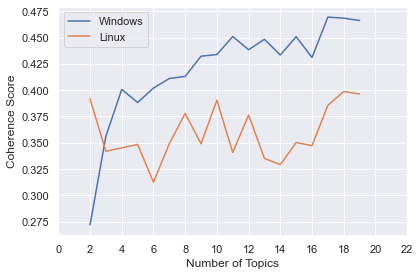

In [27]:
coherence_values_windows = []
coherence_values_linux = []
number_of_topics_windows = []
number_of_topics=[]
for num_topics in range(2, 20, 1):
    lda_model_coh_windows =   models.LdaModel(corpus=corpus_train_windows, id2word=id2word_train_windows, num_topics=num_topics, passes=100,
                           alpha='auto', per_word_topics=True, update_every=1,  random_state=123, chunksize=100) 
    lda_model_coh_linux =   models.LdaModel(corpus=corpus_train_linux, id2word=id2word_train_linux, num_topics=num_topics, passes=100,
                           alpha='auto', per_word_topics=True, update_every=1,  random_state=456, chunksize=100) 
    number_of_topics.append(num_topics)
    coherence_model_lda_windows = CoherenceModel(model=lda_model_coh_windows, texts=clean_tokenized_windows, 
                                                 dictionary=id2word_train_windows, coherence='c_v')
    coherence_values_windows.append(coherence_model_lda_windows.get_coherence())
    
    coherence_model_lda_linux = CoherenceModel(model=lda_model_coh_linux, texts=clean_tokenized_linux, 
                                                 dictionary=id2word_train_linux, coherence='c_v')
    coherence_values_linux.append(coherence_model_lda_linux.get_coherence())
sns.set()
plt.plot(number_of_topics, coherence_values_windows, label='Windows')
plt.plot(number_of_topics, coherence_values_linux, label='Linux')
labels = [0,2,4,6,8,10,12,14,16,18,20,22]
plt.xticks(labels)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.legend()
plt.tight_layout()
#plt.savefig('./results/windows_topics_coherence.png');
plt.show();

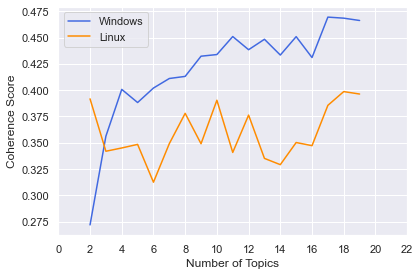

In [28]:
sns.set()
palette = ['royalblue',  'darkorange']
plt.plot(number_of_topics, coherence_values_windows, label='Windows', color='royalblue')
plt.plot(number_of_topics, coherence_values_linux, label='Linux', color='darkorange')
labels = [0,2,4,6,8,10,12,14,16,18,20,22]
plt.xticks(labels)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.legend()
plt.tight_layout()
plt.savefig('./results/windows_linux_best_topics.png');
plt.show();

In [110]:
x_df_windows.at[0, 'Result'] = 'Windows_Correct'
x_df_windows.at[1, 'Result'] = 'Windows_Incorrect'
x_df_linux.at[0, 'Result'] = 'Linux_Correct'
x_df_linux.at[1, 'Result'] = 'Linux_Incorrect'

In [111]:
x_df_windows = x_df_windows.append(x_df_linux) 

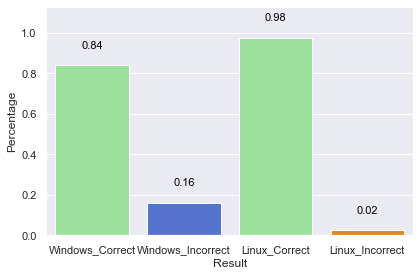

In [112]:
palette = ['lightgreen', 'royalblue', 'lightgreen', 'darkorange']
g = sns.barplot(x = 'Result', y='Ratio', data=x_df_windows, palette=palette)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.20])
ax=g
#annotate axis = seaborn axis
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                 textcoords='offset points')
_ = g.set_ylim(0,1.13) 
plt.xticks(rotation=0)
plt.ylabel('Percentage')
plt.tight_layout()
plt.savefig('./results/topic_model_validation.PNG')
plt.show()
